In [1]:
import json
import requests
import config
import time

from pyspark.sql.functions import split, expr
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, expr
from pyspark.sql.functions import col, lit, explode
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.types import StructType, StructField, StringType, MapType, TimestampType

from pyspark.sql import SparkSession





# Create a Spark session with the Kafka package
spark = SparkSession.builder \
    .appName("MarketDataProcessor") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.2") \
    .getOrCreate()


kafka_params = {
    "kafka.bootstrap.servers": "localhost:9092",
    "subscribe": "marketdata"
}


value_schema = StructType([
    StructField("symbol", StringType(), True),
    StructField("timeseries", StringType(), True),
    StructField("open", StringType(), True),
    StructField("high", StringType(), True),
    StructField("low", StringType(), True),
    StructField("close", StringType(), True),
    StructField("volume", StringType(), True),
])



# Read data from Kafka topic
kafka_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "marketdata") \
    .load()


kafka_df = kafka_df.select(from_json(col("value").cast("string"), value_schema) \
                        .alias("values"))

from pyspark.sql.functions import explode


parsed_df = kafka_df.select("values.*")

# Write the streaming DataFrame to an in-memory table
query = parsed_df \
    .writeStream \
    .format("memory") \
    .queryName("my_table") \
    .start()

# Wait for the streaming query to start
query.awaitTermination(60)

# Query the in-memory table using Spark SQL to create a static DataFrame
static_df = spark.sql("SELECT * FROM my_table")

# Show the resulting static DataFrame
# static_df.show(truncate=False)
static_df.printSchema()


# Modify the DataFrame to include "open," "high," "low," "close," and "volume" columns
df = static_df.withColumn("time", expr("split(trim('[]', timeseries), ',' )")) \
    .withColumn("open", expr("split(trim('[]', open), ',' )")) \
    .withColumn("high", expr("split(trim('[]', high), ',' )")) \
    .withColumn("low", expr("split(trim('[]', low), ',' )")) \
    .withColumn("close", expr("split(trim('[]', close), ',' )")) \
    .withColumn("volume", expr("split(trim('[]', volume), ',' )"))

# Use arrays_zip with the modified columns
df = df.withColumn("new", expr("arrays_zip(time, open, high, low, close, volume)")) \
       .withColumn("new", explode("new")) \
       .select("symbol", col("new.time").alias("timeseries"), col("new.open").alias("open"),
               col("new.high").alias("high"), col("new.low").alias("low"),
               col("new.close").alias("close"), col("new.volume").alias("volume"))

df.show(truncate=False)

jsondf = df.toJSON()

try:
    # Specify the path where you want to save the CSV file
    csv_path = "data"

    # Write the DataFrame to CSV
    csvdata = df.write.csv(csv_path, header=True, mode="overwrite")

    # Uploading to Cloud Storage
    # Create a BlobServiceClient
    blob_service_client = BlobServiceClient(account_url=f'https://{config.account_name}.blob.core.windows.net', credential=config.account_key)
    # Get a reference to the container
    container_client = blob_service_client.get_container_client(config.container_name)
    current_timestamp = time.strftime("%Y%m%d-%H%M%S")
    # Remote path (blob name) where the file will be stored in the Azure Blob Storage container
    remote_file_path = f'processed_market-data/{current_timestamp}-MSFT.json'
    # Upload the JSON string to Azure Blob Storage
    container_client.upload_blob(name=remote_file_path, data=jsondf, content_settings=ContentSettings(content_type='application/json'))
except Exception as e:
    print(e)
    pass


:: loading settings :: url = jar:file:/Users/csuftitan/Documents/Development/Adv_DB_Project/marketDataAnalysis/.venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/csuftitan/.ivy2/cache
The jars for the packages stored in: /Users/csuftitan/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fb1419b9-8f38-453d-ac47-781e8c66d946;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.1.2 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.1.2 in central
	found org.apache.kafka#kafka-clients;2.6.0 in central
	found com.github.luben#zstd-jni;1.4.8-1 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.2 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 197ms :: artifacts dl 26ms
	:: modules in use:
	com.github.luben#zstd-jni;1.4.8-1 from central in [default]
	org.apache.commons#commons-pool2;2.6.2 from

root
 |-- symbol: string (nullable = true)
 |-- timeseries: string (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)



23/12/01 03:44:08 WARN Analyzer$ResolveFunctions: Two-parameter TRIM/LTRIM/RTRIM function signatures are deprecated. Use SQL syntax `TRIM((BOTH | LEADING | TRAILING)? trimStr FROM str)` instead.


+------+---------------------+----------+----------+----------+----------+------+
|symbol|timeseries           |open      |high      |low       |close     |volume|
+------+---------------------+----------+----------+----------+----------+------+
|MSFT  |"2023-12-01 06:25:00"|"378.7700"|"378.7700"|"378.7700"|"378.7700"|"81"  |
|MSFT  |"2023-12-01 06:20:00"|"378.7700"|"378.7700"|"378.7700"|"378.7700"|"6"   |
|MSFT  |"2023-12-01 06:15:00"|"378.7300"|"378.7300"|"378.7300"|"378.7300"|"1"   |
|MSFT  |"2023-12-01 06:10:00"|"378.5900"|"378.6700"|"378.5900"|"378.6700"|"835" |
|MSFT  |"2023-12-01 06:05:00"|"378.5700"|"378.6500"|"378.5700"|"378.5900"|"331" |
|MSFT  |"2023-12-01 06:00:00"|"378.6100"|"378.6600"|"378.5300"|"378.5500"|"149" |
|MSFT  |"2023-12-01 05:55:00"|"378.6600"|"378.6800"|"378.6300"|"378.6600"|"178" |
|MSFT  |"2023-12-01 05:50:00"|"378.6700"|"378.6700"|"378.6700"|"378.6700"|"1"   |
|MSFT  |"2023-12-01 05:45:00"|"378.7500"|"378.7500"|"378.7000"|"378.7000"|"6"   |
|MSFT  |"2023-12

In [6]:
pdf_market_data.head(20)

,symbol,timeseries,open,high,low,close,volume,date,7_day_SMA,30_day_SMA
99,MSFT,2023-11-30 14:10:00,375.850,376.430,375.850,376.410,136100.0,2023-11-30 14:10:00,NaN,NaN
98,MSFT,2023-11-30 14:15:00,376.415,376.600,376.210,376.260,133509.0,2023-11-30 14:15:00,NaN,NaN
97,MSFT,2023-11-30 14:20:00,376.240,376.250,375.970,376.090,146479.0,2023-11-30 14:20:00,NaN,NaN
96,MSFT,2023-11-30 14:25:00,376.080,376.120,375.800,375.840,165698.0,2023-11-30 14:25:00,NaN,NaN
95,MSFT,2023-11-30 14:30:00,375.860,376.190,375.780,375.985,132296.0,2023-11-30 14:30:00,NaN,NaN
94,MSFT,2023-11-30 14:35:00,375.980,376.130,375.820,375.940,107035.0,2023-11-30 14:35:00,NaN,NaN
93,MSFT,2023-11-30 14:40:00,375.936,376.350,375.930,376.330,103733.0,2023-11-30 14:40:00,376.122143,NaN
92,MSFT,2023-11-30 14:45:00,376.330,376.759,376.310,376.740,170653.0,2023-11-30 14:45:00,376.169286,NaN
91,MSFT,2023-11-30 14:50:00,376.730,376.780,376.490,376.680,147365.0,2023-11-30 14:50:00,376.229286,NaN
90,MSFT,2023-11-30 14:55:00,376.680,376.730,376.500,376.580,129329.0,2023-11-30 14:55:00,376.299286,NaN


23/12/01 12:28:12 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

DataFrame[symbol: string, timeseries: string, open: string, high: string, low: string, close: string, volume: string]


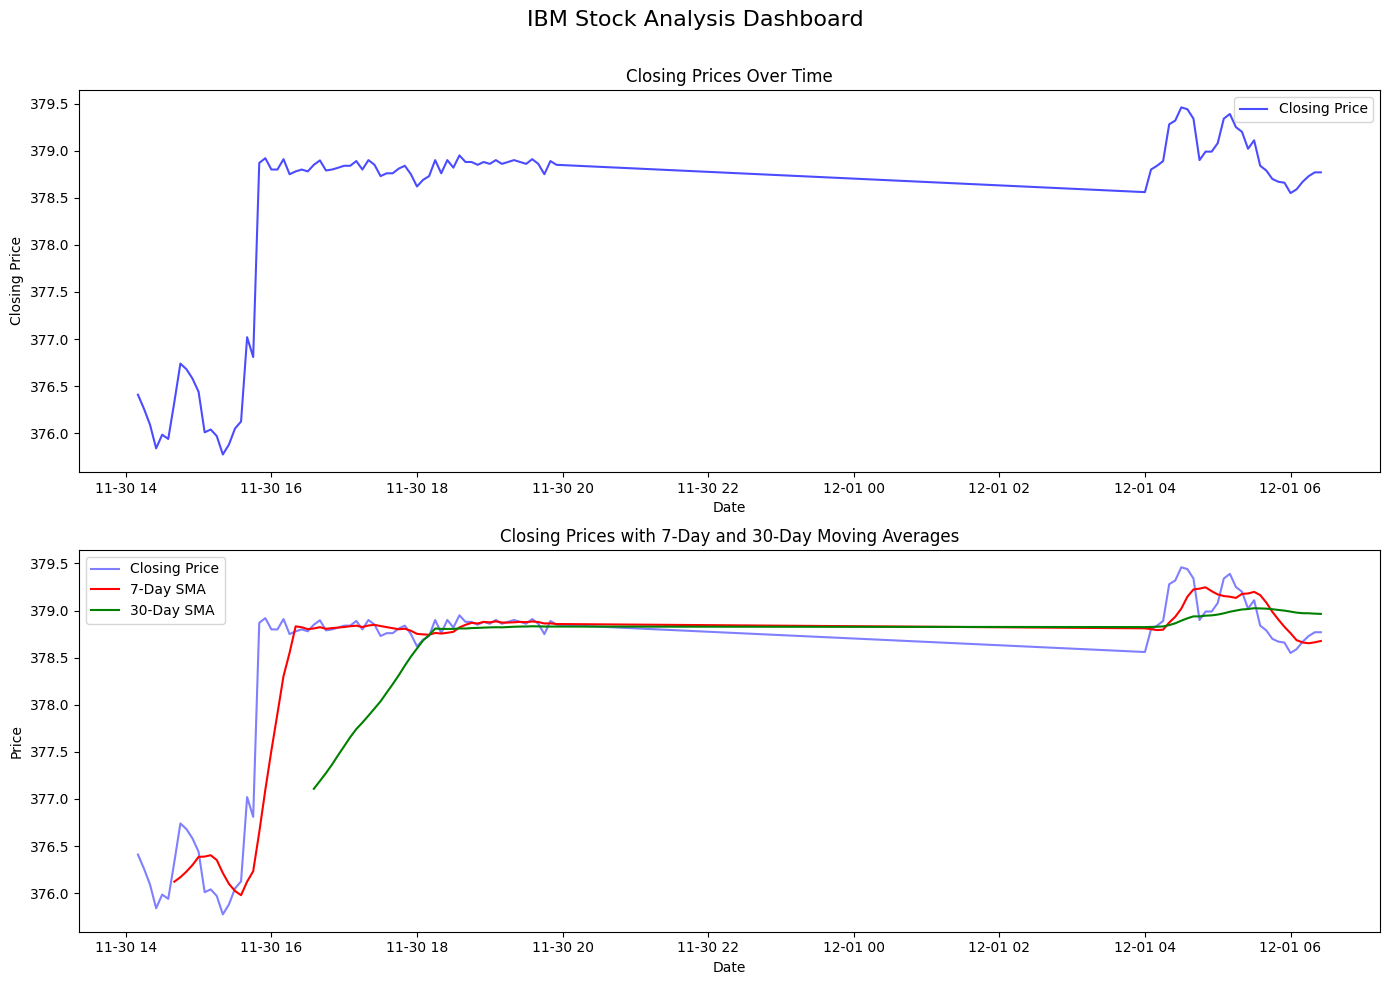

In [2]:


import matplotlib.pyplot as plt
import pandas as pd


# Convert Spark DataFrame to Pandas DataFrame for plotting
pdf_market_data = df.toPandas()

pdf_market_data['open'] = pdf_market_data['open'].str.strip('"')
pdf_market_data['high'] = pdf_market_data['high'].str.strip('"')
pdf_market_data['low'] = pdf_market_data['low'].str.strip('"')
pdf_market_data['close'] = pdf_market_data['close'].str.strip('"')
pdf_market_data['volume'] = pdf_market_data['volume'].str.strip('"')


pdf_market_data['open'] = pdf_market_data['open'].astype(float)
pdf_market_data['low'] = pdf_market_data['low'].astype(float)
pdf_market_data['high'] = pdf_market_data['high'].astype(float)
pdf_market_data['close'] = pdf_market_data['close'].astype(float)
pdf_market_data['volume'] = pdf_market_data['volume'].astype(float)

# Ensure 'timeseries' column is of string type
pdf_market_data['timeseries'] = pdf_market_data['timeseries'].astype(str)

# Remove double quotes around the timestamp string
pdf_market_data['timeseries'] = pdf_market_data['timeseries'].str.strip('"')

# Convert 'date' column to datetime type
pdf_market_data['date'] = pd.to_datetime(pdf_market_data['timeseries'], format='%Y-%m-%d %H:%M:%S')

# Sort the DataFrame by date
pdf_market_data.sort_values('date', inplace=True)

# Setting up the figure for the dashboard
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))
fig.suptitle("IBM Stock Analysis Dashboard", fontsize=16)

# Plot 1: Closing Prices
axes[0].plot(pdf_market_data['date'].values, pdf_market_data['close'].values, label='Closing Price', color='blue', alpha=0.7)
axes[0].set_title('Closing Prices Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Closing Price')
axes[0].legend()

# Calculate the moving averages
pdf_market_data['7_day_SMA'] = pdf_market_data['close'].rolling(window=7).mean()
pdf_market_data['30_day_SMA'] = pdf_market_data['close'].rolling(window=30).mean()

# Plot 2: Moving Averages
axes[1].plot(pdf_market_data['date'].values, pdf_market_data['close'].values, label='Closing Price', color='blue', alpha=0.5)
axes[1].plot(pdf_market_data['date'].values, pdf_market_data['7_day_SMA'].values, label='7-Day SMA', color='red')
axes[1].plot(pdf_market_data['date'].values, pdf_market_data['30_day_SMA'].values, label='30-Day SMA', color='green')
axes[1].set_title('Closing Prices with 7-Day and 30-Day Moving Averages')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the dashboard
plt.show()

In [7]:
import plotly.express as px
fig = px.bar(pdf_market_data, x='timeseries', y='volume', color='symbol', title='Trading Volume Over Time')
fig.show()


23/12/01 12:30:42 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

In [8]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=pdf_market_data['timeseries'],
                open=df.toPandas()['open'],
                high=df.toPandas()['high'],
                low=df.toPandas()['low'],
                close=df.toPandas()['close'])])

fig.update_layout(title='Candlestick Chart', xaxis_title='Time', yaxis_title='Price')
fig.show()


In [9]:
fig = px.line(pdf_market_data, x='timeseries', y=['open', 'low', 'close'],
              labels={'value': 'Stock Price', 'timeseries': 'Time'},
              title='Stock Price Over Time with Moving Averages')
fig.show()


23/12/01 12:30:52 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [10]:

pdf_market_data['daily_return'] = pdf_market_data['close'].pct_change()
fig = px.scatter(pdf_market_data, x='timeseries', y='daily_return', color='symbol', title='Daily Returns')
fig.show()


23/12/01 12:31:02 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)